In [1]:
import torch
import os
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
from yolo_code_that_we_use import *
from tqdm.notebook import tqdm
from confusion_matrix_class import ConfusionMatrix


from pix2pockets_interpolation import HomographyMapping
#from AUC
from pix2pockets_import import get_label,compare_post_process,evaluate_batch,table_analysis,load_dataset,set_im_and_label_paths_to_all
#from main
from pix2pockets_import import load_detection_model,get_detection,helper_plot_bbox,plot_bboxes

%matplotlib inline

In [2]:
dataset_name = 'dataset155'
# dataset_name = 'datasets\\pool100_dataset'
folder_type = 'test'
#folder_type = 'train'
model, im_paths, label_paths, name1 = load_dataset(dataset_name, folder_type)

Found weight path: dataset155/155best_2000.pt


Using cache found in /Users/viktorsebastianpetersen/.cache/torch/hub/ultralytics_yolov5_master
/Users/viktorsebastianpetersen/opt/anaconda3/envs/PoolRL/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
YOLOv5 🚀 2025-5-29 Python-3.9.18 torch-2.2.0 CPU

Fusing layers... 
YOLOv5s_pool summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [3]:
save_folder = 'plot_export/'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

saved to plot_export/compare_post_procsess.png


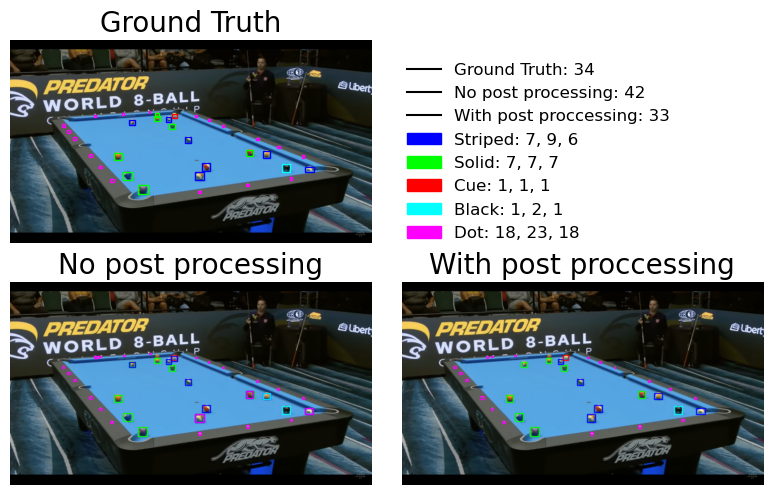

In [4]:
%matplotlib inline

img_id = 12
im = cv2.imread(im_paths[img_id])[:,:,::-1]
im_size = im.shape[:2]
labels = get_label(label_paths[img_id], im_size)
_,detections = get_detection(im_paths[img_id], model, post_process=False, conf_thresh=0, iou_thresh=0,output_format='corner')
# detections = np.concatenate((detections[:,5:], detections[:,:4]), axis=1)
_,detections_post = get_detection(im_paths[img_id], model,output_format='corner')

compare_post_process(im, labels, detections, detections_post,save_path=save_folder+'compare_post_procsess.png')


saved to plot_export/plot_bboxes_38.png


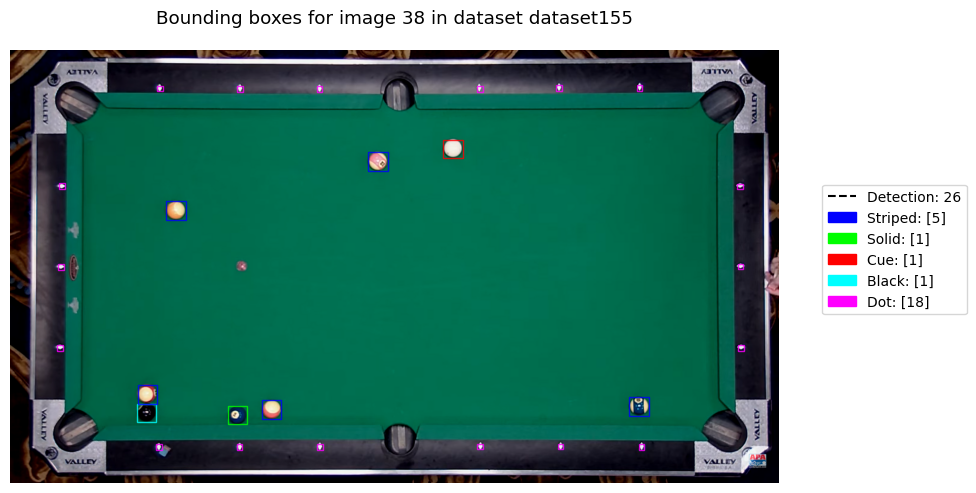

In [5]:
%matplotlib inline

# Plot bounding boxes for each image in the folder
im_idxes = [4]
for im_idx in im_idxes:
    im = cv2.imread(im_paths[im_idx])[:,:,::-1]
    im_size = im.shape[:2]
    
    _,detections = get_detection(im_paths[im_idx], model, post_process=True)
    # labels = get_label(label_paths[im_idx], im_size)
    labels = None
    
    pathstr = r"{path}".format(path = im_paths[im_idx]) # accomodate windows and mac differences
    if '\\' in pathstr:
        im_number = int(r"{path}".format(path = im_paths[im_idx]).split('\\')[-1].split('.')[0])
    else:
        im_number = int(r"{path}".format(path = im_paths[im_idx]).split('/')[-1].split('.')[0])
    
    classes_to_plot=['Striped', 'Solid', 'Cue', 'Black', 'Dot']
    plot_bboxes(im, labels, detections, im_idx= im_number, data_name=name1, legend=True,save_path=save_folder+f'plot_bboxes_{im_number}.png')

In [6]:
# results = model(im_paths[0])
# results.pandas().xywh[0]

## Main

Load model and get detection from images in a folder. These will function as the states for the RL environment.

In [7]:
save_folder = 'plot_export/'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

In [8]:
datanum = 21
im_path = f'dataset155/test/images/{datanum}.png'
model_path = 'dataset155/155best_2000.pt'

detection_model = load_detection_model(model_path)

Using cache found in /Users/viktorsebastianpetersen/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-5-29 Python-3.9.18 torch-2.2.0 CPU

Fusing layers... 
YOLOv5s_pool summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


saved to plot_export/plot_bboxes_38.png


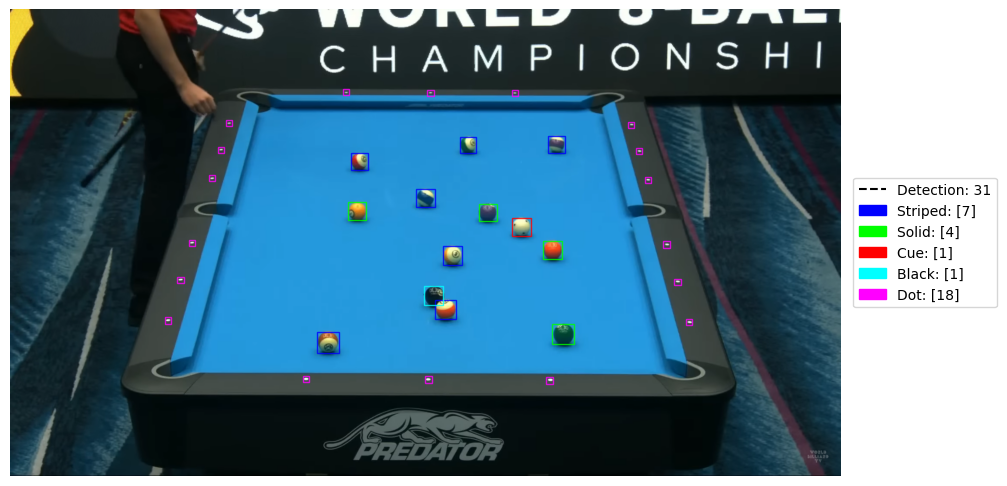

In [9]:
%matplotlib inline

image, detections = get_detection(im_path=im_path, model=detection_model, post_process=True)
plot_bboxes(image, None, detections,save_path=save_folder+f'plot_bboxes_{im_number}.png')

image_as_cv2 = cv2.imread(im_path)[:,:,::-1] # TODO: fix this to work with image directly

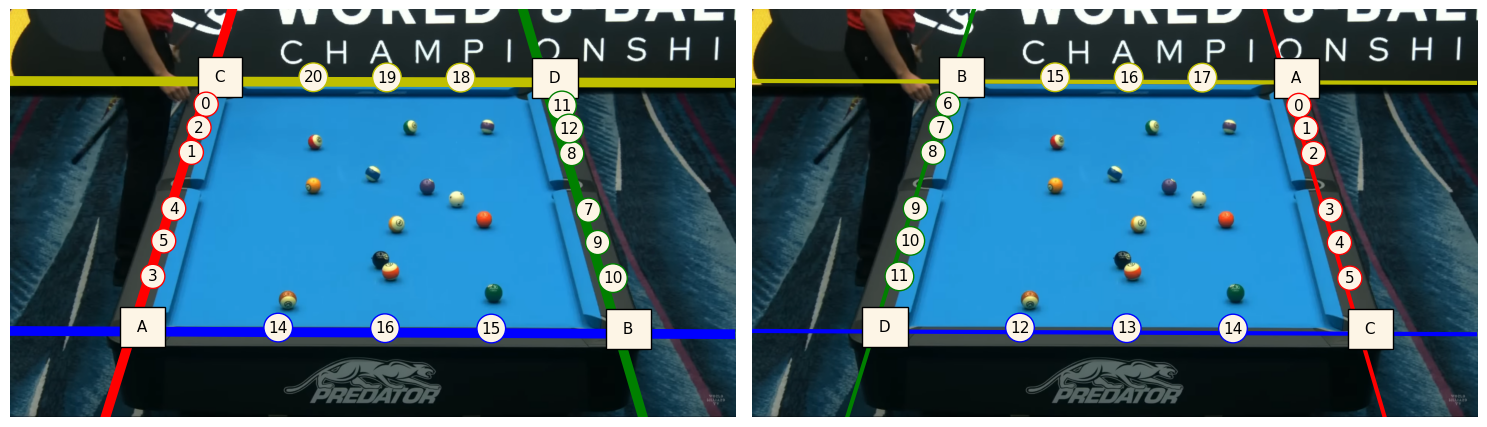

In [10]:
%matplotlib inline
# Use HomographyMapping to extract lines and convert to RL environment format

label = 't' # used for saving files only
thres = 3

dots_newformat = detections[detections[:, 5]==4]
balls_newformat = detections[detections[:, 5]!=4]

Object = HomographyMapping(label,dots_newformat[:,0:2],thres,image_as_cv2,balls_newformat[:,0:2],datanum,save_folder)
Object.extract_lines()

Object.plot_lines(save=True)
# Object.plot_template(save=True)

# extract results from topview image
H, template_points, found_points, ball_H, dist_error, viewtype, warpedim = Object.extract_things_we_might_need()

### plot_compare2topview

In [26]:
#load images from the doublecam folder

datanum = 3

ims = []
annot = []
centers = []
labels = []

types = ["t","f","a"]
if [os.path.exists(f'doublecam_dataset/train/images/{str(datanum)}{type}.jpg') for type in types].count(True) == 3:
    types = ["t","f","t","a"]

for type in types:
    im_path = f'doublecam_dataset/train/images/{str(datanum)}{type}.jpg'
    txt_path = f'doublecam_dataset/train/labelTxt/{str(datanum)}{type}.txt'

    centerpoint_vertical = 0.5 if type=='t' else 0.2
    if os.path.exists(im_path):
        labels.append(type)
        ims.append(cv2.imread(im_path)[:,:,::-1])
        here = [i.split()[:9] for i in open(txt_path).read().split("\n")]
        now = []
        for p in here:
            now.append([int(float(p[0]) - 0.5*(float(p[0])-float(p[2]))),
                        int(float(p[3]) - centerpoint_vertical*(float(p[3])-float(p[5])))
                        ]+[p[8]])
        centers.append(now)
        annot.append([[int(round(float(j))) for j in i.split()[:8]]+[i.split()[8]] for i in open(txt_path).read().split("\n")])

ball_centers = []
dot_centers = []
classes = []
for i in centers:
    ball_centers.append(np.array([i[:2] for i in i if i[-1]!='Dot']))
    dot_centers.append(np.array([i[:2] for i in i if i[-1]=='Dot']))
    # classes.append(np.array([i[2] for i in i if i[-1]!='Dot']))
    classes.append([])
    
print(labels)

['t', 'f']


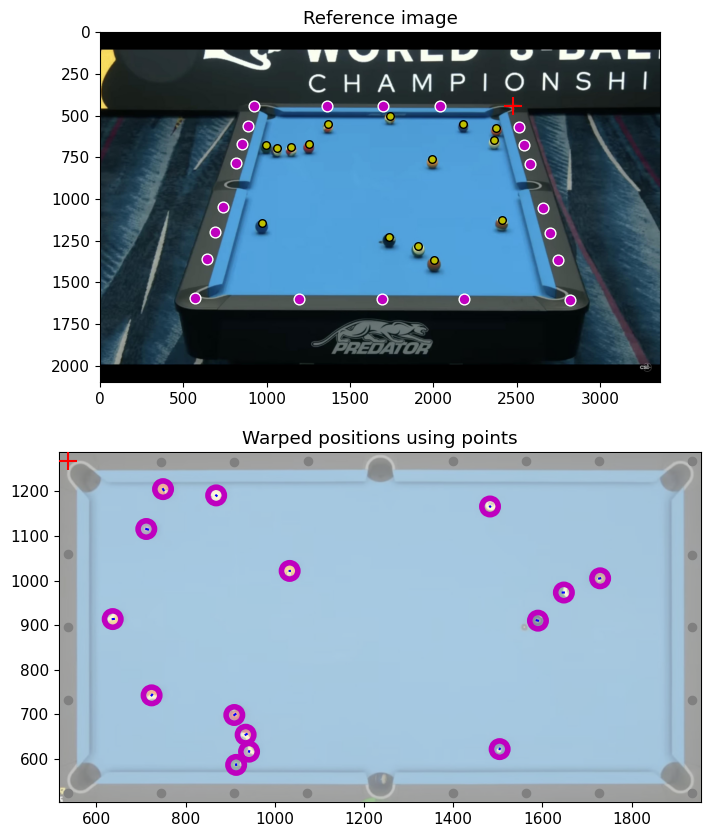

In [ ]:
thres=3

#topview image:
im_no = 0
Object_0 = HomographyMapping(labels[im_no],dot_centers[im_no],thres,ims[im_no],ball_centers[im_no],datanum,save_folder)
Object_0.extract_lines()
# Object_0.plot_lines(save=True)

# fronview image:
im_no = 1
Object_1 = HomographyMapping(labels[im_no],dot_centers[im_no],thres,ims[im_no],ball_centers[im_no],datanum,save_folder)
Object_1.extract_lines()
# Object_1.plot_lines(save=True)

# extract results from image
H0, template_points0, found_points0, ball_H0, dist_error0, viewtype0, warpedim0 = Object_0.extract_things_we_might_need()

# plot compare2topview
Object_1.plot_compare2topview(compareballs=ball_H0, warpedim=warpedim0)

# POOL ENV

In [ ]:
import gymnasium as gym

from RL_Pool_env3 import PoolEnv
from RL_config_env import *
from RL_functions import run_model, load_RL_model

from RL_custom_evaluate_policy import custom_evaluate_policy
from RL_custom_evaluate_policy import custom_evaluate_policy_masked

from stable_baselines3 import PPO, TD3, A2C, DDPG, SAC
from stable_baselines3.common.env_util import make_vec_env

from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker
from sb3_contrib.ppo_mask import MaskablePPO

ImportError: cannot import name 'register_policy' from 'stable_baselines3.common.policies' (/Users/viktorsebastianpetersen/opt/anaconda3/envs/PoolRL/lib/python3.9/site-packages/stable_baselines3/common/policies.py)

In [20]:
# Setup
ALGO = "PPO_masked"  # PPO_masked  TD3  PPO  SAC DDPG A2C
CHEAT = False
nb = 16  # Number of balls.

# Load learned states
assert nb == 1 or nb == 2 or nb == 16
if nb == 2: ls = np.load("1_000_000_states.npy")
elif nb == 16: ls = np.load("1_000_000_states_full_table.npy")
else: ls = None

# Try with image above
# ls = detections[detections[:, -1] != 4][:, [0, 1, -1]]  # Get only ball detections and keep only x,y and class values

env_kwargs = dict(
    algo=ALGO,
    balls_init=ls,
    suit=2,
    training=False,
    fps=60,  # 60
    num_balls=nb,
    special_state=None,  # 497852  666
    obs_type='vector',
    sigma=0,
    cheat_force=CHEAT,
    cheat_angle=CHEAT,
    game_type='normal',  # 'blue_only' or 'normal'
    bank_shots=False
)

use_masking = True if ALGO == 'PPO_masked' else False

In [21]:
RL_model, env = load_RL_model(ALGO, env_kwargs)
run_model(RL_model, env, max_steps=100, render=True, use_masking=use_masking)

Using PPO_masked algorithm


AttributeError: 'Space' object has no attribute 'add_collision_handler'

#### Ignore

In [21]:
def mask_fn(env: gym.Env) -> np.ndarray:
    # Do whatever you'd like in this function to return the action mask
    # for the current env. In this example, we assume the env has a
    # helpful method we can rely on.
    return env.valid_action_mask()


if __name__ == "__main__":
    # Settings
    obs_type = "vector"
    LOG = False
    TRAINING = False
    CHEAT = False
    timesteps = 1_200_000
    n_envs = 1

    # save_path = 'final_tests'
    nb = 16
    ALGO = "PPO_masked"  # PPO_masked  TD3  PPO  SAC DDPG A2C
    LOAD_MODEL = True

    assert nb == 1 or nb == 2 or nb == 16
    if nb == 2: ls = np.load("1_000_000_states.npy")
    elif nb == 16: ls = np.load("1_000_000_states_full_table.npy")
    else: ls = None
    
    env_kwargs = dict(
        algo=ALGO,
        balls_init=ls,
        suit=2,
        training=TRAINING,
        fps=60,  # 60
        num_balls=nb,
        special_state=None,  # 497852  666
        obs_type=obs_type,
        sigma=0,
        cheat_force=CHEAT,
        cheat_angle=CHEAT,
        game_type='normal',  # 'blue_only' or 'normal'
        bank_shots=False
    )
    env = make_vec_env(PoolEnv, seed=1, n_envs=n_envs, env_kwargs=env_kwargs)
    print(f"LOAD_MODEL: {LOAD_MODEL}")
    if ALGO != "PPO_masked":
        model_path = f"RL_models/{ALGO}.zip"
        if ALGO == "PPO":
            if LOAD_MODEL: model = PPO.load(model_path, env)
            else: model = PPO(policy='MlpPolicy', env=env)
        elif ALGO == "TD3":
            if LOAD_MODEL: model = TD3.load(model_path, env)
            else: model = TD3(policy='MlpPolicy', env=env)
        elif ALGO == "A2C":
            if LOAD_MODEL: model = A2C.load(model_path, env)
            else: model = A2C(policy='MlpPolicy', env=env)
        elif ALGO == "SAC":
            if LOAD_MODEL: model = SAC.load(model_path, env=env)
            else: model = SAC(model_path, env)
        elif ALGO == "DDPG":
            if LOAD_MODEL: model = DDPG.load(model_path, env=env)
            else: model = DDPG(model_path, env)

        # results = run_model(model, env, 1000, render=False)
        mean_reward, std_reward, sr, er = custom_evaluate_policy(
            model, env, n_eval_episodes=500, warn=False)

    else:
        env = PoolEnv(**env_kwargs)         # Initialize environment
        env = ActionMasker(env, mask_fn)    # Wrap to enable masking

        # policy_kwargs = dict(activation_fn=torch.nn.ReLU,
        #                      net_arch=dict(pi=[400, 300], vf=[400, 300]))

        model_kwargs = dict(
            policy=MaskableActorCriticPolicy,
            env=env,
            batch_size=256,
            # learning_rate=lr_schedule_linear(3e-4),
            # policy_kwargs=policy_kwargs,
            n_steps=2048,
            verbose=1
            # device='cuda'
        )

        model_path = f"RL_models/{ALGO}.zip"
        model2 = MaskablePPO.load(model_path, env)

        mean_reward, std_reward, sr, er = custom_evaluate_policy_masked(
            model2, env, n_eval_episodes=500, warn=False)


Using PPO_masked algorithm
------------------------------
LOAD_MODEL: True
Using PPO_masked algorithm
------------------------------
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.



--------------------------------------------------
Action                    Angle:  171.92
                          Force:  314.14

- reward off
pocketed_suit             50.00 with spec: ball 12 
first_hit_none            -7.36 with spec:  0.15 
- reward off
target_angle_pocket       41.58 with spec:  0.92 
--------------------------------------------------
Total Reward              84.22
Total Reward (normalized):     0.4011
--------------------------------------------------




--------------------------------------------------
Action                    Angle: -102.15
                          Force:  381.72

- reward off
- reward off
hit_suit                  10.00 
- reward off
target_angle_pocket       7.33 with spec:  7.44 
--------------------------------------------

SystemExit: 